In [1]:
import numpy as np
import pandas as pd 
import astropy.io.ascii as ascii
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import PIL
from PIL import Image
import sys
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.image as mp
from astropy.visualization import LinearStretch
from astropy.visualization import ZScaleInterval
from astropy.visualization import ImageNormalize

In [2]:
def match1(poi, catalogue):
    
    x=poi['X_WORLD']
    y=poi['Y_WORLD']

    coord1 = SkyCoord(ra=[x]*u.degree, dec=[y]*u.degree)
    coord2 = SkyCoord(ra=catalogue['X_WORLD']*u.degree, dec=catalogue['Y_WORLD']*u.degree)

    idx, d2d, d3d = coord1.match_to_catalog_sky(coord2)
    max_sep = 1.0 * u.arcsec
    sep_constraint = d2d < max_sep
    global catalogue_match
    catalogue_match = catalogue.iloc[idx[sep_constraint]]
def match2(catalogue1, catalogue2):
    xworld1 = catalogue1['X_WORLD']
    yworld1 = catalogue1['Y_WORLD']

    xworld2 = catalogue2['X_WORLD']
    yworld2 = catalogue2['Y_WORLD']

    coord1 = SkyCoord(ra=xworld1*u.degree, dec=yworld1*u.degree)
    coord2 = SkyCoord(ra=xworld2*u.degree, dec=yworld2*u.degree)

    idx, d2d, d3d = coord1.match_to_catalog_sky(coord2)

    max_sep = 1.0 * u.arcsec

    sep_constraint = d2d < max_sep

    global data1_12_matches
    try: data1_12_matches = catalogue1[sep_constraint]
    except IndexError: 
        pass 
    
    global data2_12_matches
    data2_12_matches = catalogue2.iloc[idx[sep_constraint]]

def match3(catalogue1, catalogue2, catalogue3):
    xworld1 = catalogue1['X_WORLD']
    yworld1 = catalogue1['Y_WORLD']

    xworld2 = catalogue2['X_WORLD']
    yworld2 = catalogue2['Y_WORLD']
    
    xworld3 = catalogue3['X_WORLD']
    yworld3 = catalogue3['Y_WORLD']
    
    coord1 = SkyCoord(ra=xworld1*u.degree, dec=yworld1*u.degree)
    coord2 = SkyCoord(ra=xworld2*u.degree, dec=yworld2*u.degree)

    
    idx, d2d, d3d = coord1.match_to_catalog_sky(coord2)
    
    max_sep = 1.0 * u.arcsec

    sep_constraint = d2d < max_sep
    
    data1_12_matches = catalogue1[sep_constraint]
    data2_12_matches = catalogue2.iloc[idx[sep_constraint]]
    
    xworld1_12 = data1_12_matches['X_WORLD']
    yworld1_12 = data1_12_matches['Y_WORLD']
    
    coord1_12 = SkyCoord(ra=xworld1_12*u.degree, dec=yworld1_12*u.degree)
    coord3 = SkyCoord(ra=xworld3*u.degree, dec=yworld3*u.degree)
    
    idx, d2d, d3d = coord1_12.match_to_catalog_sky(coord3)
    
    max_sep = 1.0 * u.arcsec

    sep_constraint = d2d < max_sep
    
    global data1_123_matches
    data1_123_matches = data1_12_matches[sep_constraint]
    global data2_123_matches
    data2_123_matches = data2_12_matches[sep_constraint]
    global data3_123_matches
    data3_123_matches = catalogue3.iloc[idx[sep_constraint]]

In [3]:
#reading in the cat files" 
parameters08g = ascii.read("GRB210605A5_20210608_g_stack_ext5.resamp_sub_withnans_SUB.cat")
parameters09g = ascii.read("GRB210605A5_20210609_g_stack_ext5.resamp_sub_withnans_SUB.cat")
parameters10g = ascii.read("GRB210605A5_20210610_g_stack_ext5.resamp_sub_withnans_SUB.cat")

#initialising the panda dataframes
data08g = pd.DataFrame(parameters08g.as_array())
data09g = pd.DataFrame(parameters09g.as_array())
data10g = pd.DataFrame(parameters10g.as_array())

#filtering out the 'fake' data
data08gf = data08g[data08g['MAG_AUTO'] < 20]
data09gf = data09g[data09g['MAG_AUTO'] < 20]
data10gf = data10g[data10g['MAG_AUTO'] < 20]

In [4]:
match3(data08gf, data09gf, data10gf)

xworld1_123 = data1_123_matches['X_WORLD']
yworld1_123 = data1_123_matches['Y_WORLD']

xworld2_123 = data2_123_matches['X_WORLD']
yworld2_123 = data2_123_matches['Y_WORLD']

xworld3_123 = data3_123_matches['X_WORLD']
yworld3_123 = data3_123_matches['Y_WORLD']

# Stamps for the images

In [28]:
def fits_read(fits_file, xworld_data, yworld_data): #fits is a fits image file, xworld/yworld data are the coordinates of 
    fits = fits_file
    hdu_list = fits.open(fits)
    image_data = hdu_list[0].data
    global wmap 
    global xcentre
    global ycentre
    wmap = WCS(hdu_list[0].header)
    (xcentre,ycentre) = wmap.wcs_world2pix(xworld_data, yworld_data, 0)
    hdu_list.close()
    
def fits_draw(xworld, yworld, pixel_size, image_type, file_name):
    (xcentre, ycentre) = wmap.wcs_world2pix(xworld, yworld, 0)
    image_centre_x = int(ycentre)
    image_centre_y = int(xcentre)
    
    imagecut=image_data[image_centre_x-size:image_centre_x+size,image_centre_y-size:image_centre_y+size]
    wmapcut=wmap[image_centre_x-size:image_centre_x+size,image_centre_y-size:image_centre_y+size]
    plt.clf()
    
    plt.figure(figsize=(6, 6), dpi=80)    
    plt.subplots_adjust(left=.25)
    ax = plt.subplot(projection=wmapcut, label='overlays')
    ax.get_transform('fk5')
    norm = ImageNormalize(imagecut, interval=ZScaleInterval(),stretch=LinearStretch())
    ax.imshow(imagecut, norm = norm, cmap='gray')
    
    ax.coords[1].set_format_unit(u.degree)
    ax.coords[0].set_format_unit(u.degree)
    ax.coords[0].set_axislabel('\nRight Ascension \n ' + str(image_type) + ' \n', fontsize=10)
    ax.coords[1].set_axislabel('Declination',fontsize=10)            


    plt.savefig(str(file_name) + '.png', format="png")
    plt.show()
    

In [29]:
temp_file = 'GRB210605A5_g_stacked_temp.resamp.fits'

fits_read('GRB210605A5_g_stacked_temp.resamp.fits', xworld1_123, yworld1_123)

AttributeError: 'str' object has no attribute 'open'

In [13]:
temp_file = 'GRB210605A5_g_stacked_temp.resamp.fits'

# sci08_file = 'GRB210605A5_20210608_g_stack_ext5.resamp_withnans.fits'
# sub08_file = 'GRB210605A5_20210608_g_stack_ext5.resamp_sub_withnans.fits'

# sci09_file = 'GRB210605A5_20210609_g_stack_ext5.resamp_withnans.fits'
# sub09_file = 'GRB210605A5_20210609_g_stack_ext5.resamp_sub_withnans.fits'

sci10_file = 'GRB210605A5_20210610_g_stack_ext5.resamp_withnans.fits'
# sub10_file = 'GRB210605A5_20210610_g_stack_ext5.resamp_sub_withnans.fits'


hdu_list = fits.open(temp_file)
# hdu_list = fits.open(sci10_file)
# hdu_list = fits.open(sub10_file)
hdu_list.info()

image_data = hdu_list[0].data
wmap = WCS(hdu_list[0].header)
(xcentre,ycentre) = wmap.wcs_world2pix(xworld1_123, yworld1_123, 0)
# print((xcentre,ycentre))

print(type(image_data))
print(image_data.shape)

hdu_list.close()

Filename: GRB210605A5_g_stacked_temp.resamp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (9892, 8965)   float32   
<class 'numpy.ndarray'>
(8965, 9892)


C:\Users\Minh\anaconda3\lib\site-packages\astropy\visualization\wcsaxes\core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
C:\Users\Minh\anaconda3\lib\site-packages\astropy\visualization\wcsaxes\core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


<Figure size 432x288 with 0 Axes>

C:\Users\Minh\anaconda3\lib\site-packages\astropy\visualization\wcsaxes\core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
C:\Users\Minh\anaconda3\lib\site-packages\astropy\visualization\wcsaxes\core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


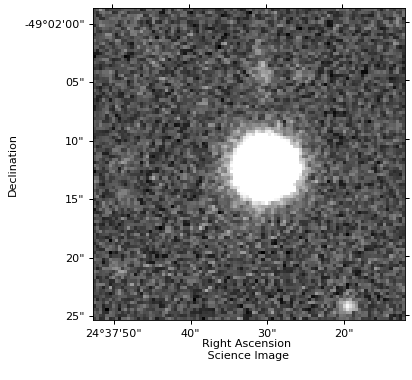

In [6]:
# ra and dec of the source of interest
xworld = 24.625575
yworld = -49.036627

size = 50


(xcentre, ycentre) = wmap.wcs_world2pix(xworld, yworld, 0)
image_centre_x = int(ycentre)
image_centre_y = int(xcentre)
imagecut=image_data[image_centre_x-size:image_centre_x+size,image_centre_y-size:image_centre_y+size]
wmapcut=wmap[image_centre_x-size:image_centre_x+size,image_centre_y-size:image_centre_y+size]
plt.clf()
plt.figure(figsize=(6, 6), dpi=80)    
plt.subplots_adjust(left=.25)
ax = plt.subplot(projection=wmapcut, label='overlays')
ax.get_transform('fk5')
norm = ImageNormalize(imagecut, interval=ZScaleInterval(),stretch=LinearStretch())
ax.imshow(imagecut, norm = norm, cmap='gray')
ax.coords[1].set_format_unit(u.degree)
ax.coords[0].set_format_unit(u.degree)
ax.coords[0].set_axislabel('\nRight Ascension \n Science Image \n', fontsize=10)
# ax.coords[0].set_axislabel('\nRight Ascension \n Subtraction Image \n', fontsize=10)
ax.coords[1].set_axislabel('Declination',fontsize=10)            


plt.savefig('Stamp_sci10.png', format="png")
# plt.savefig('Stamp_sub10.png', format="png")
plt.show()


In [7]:
#  I print 3 stamps (template, science and subtracted) and save it to an output file for 3 days

# template image 
temp = 'Stamp_temp.png'

# day08 
# template1 = 'Stamp_temp08.png'
science1 = 'Stamp_sci08.png'
subtraction1 = 'Stamp_sub08.png'

#  day09
# template2 = 'Stamp_temp09.png'
science2 = 'Stamp_sci09.png'
subtraction2 = 'Stamp_sub09.png'

#  day10
# template3 = 'Stamp_temp10.png'
science3 = 'Stamp_sci10.png'
subtraction3 = 'Stamp_sub10.png'

o1 = 'stamp08.png'
o2 = 'stamp09.png'
o3 = 'stamp10.png'

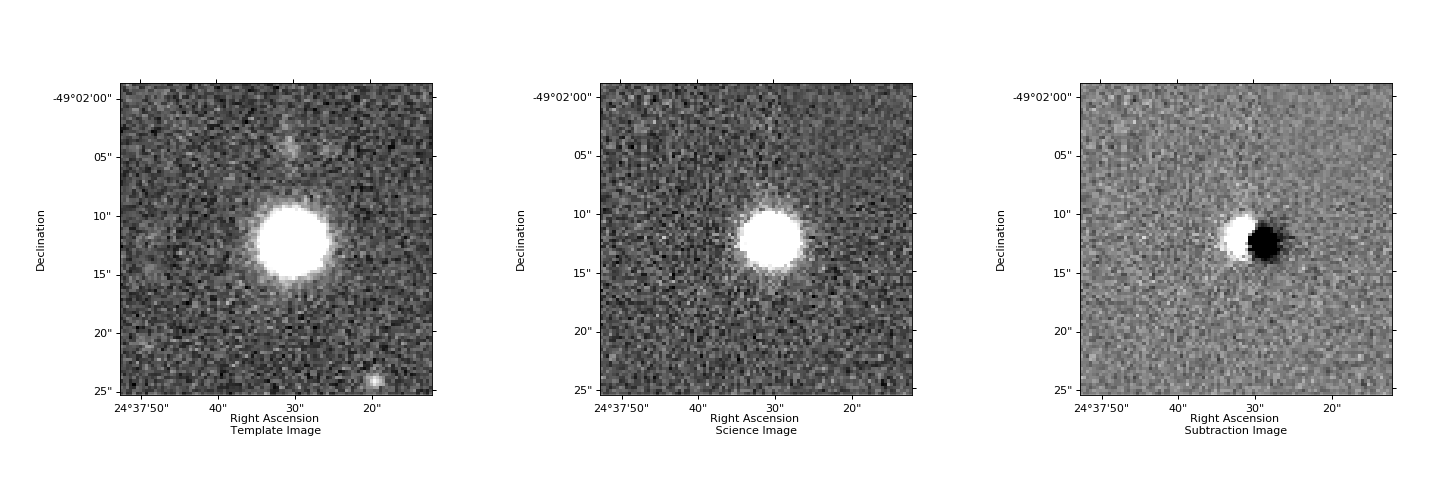

In [8]:
#  day08 Combine Horizontally
images = [Image.open(x) for x in [temp, science1, subtraction1]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(o1)
test = Image.open('stamp08.png')
test

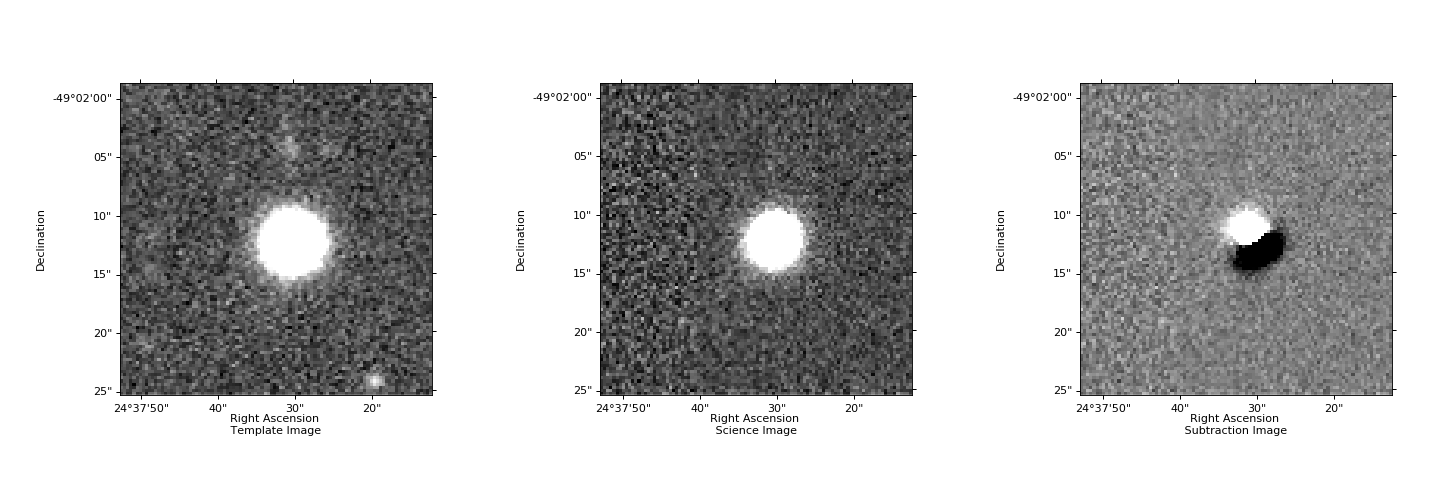

In [9]:
# day09 Combine Horizontally
images = [Image.open(x) for x in [temp, science2, subtraction2]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(o2)
test = Image.open('stamp09.png')
test


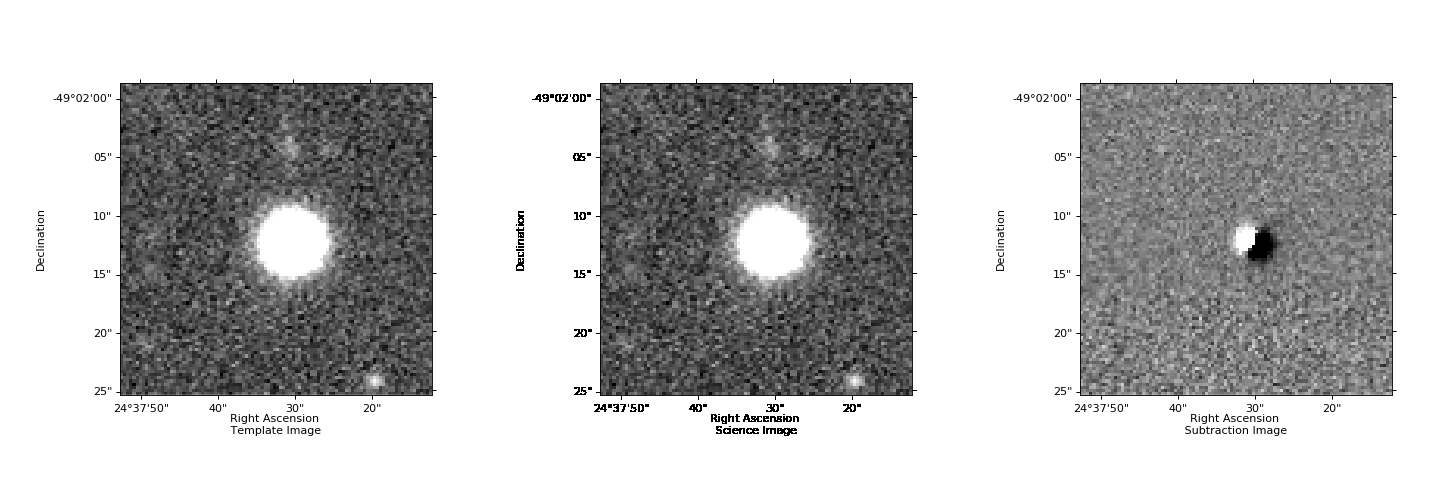

In [10]:
# day10 Combine Horizontally

images = [Image.open(x) for x in [temp, science3, subtraction3]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(o3)
test = Image.open('Stamp10.png')
test

C:\Users\Minh\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


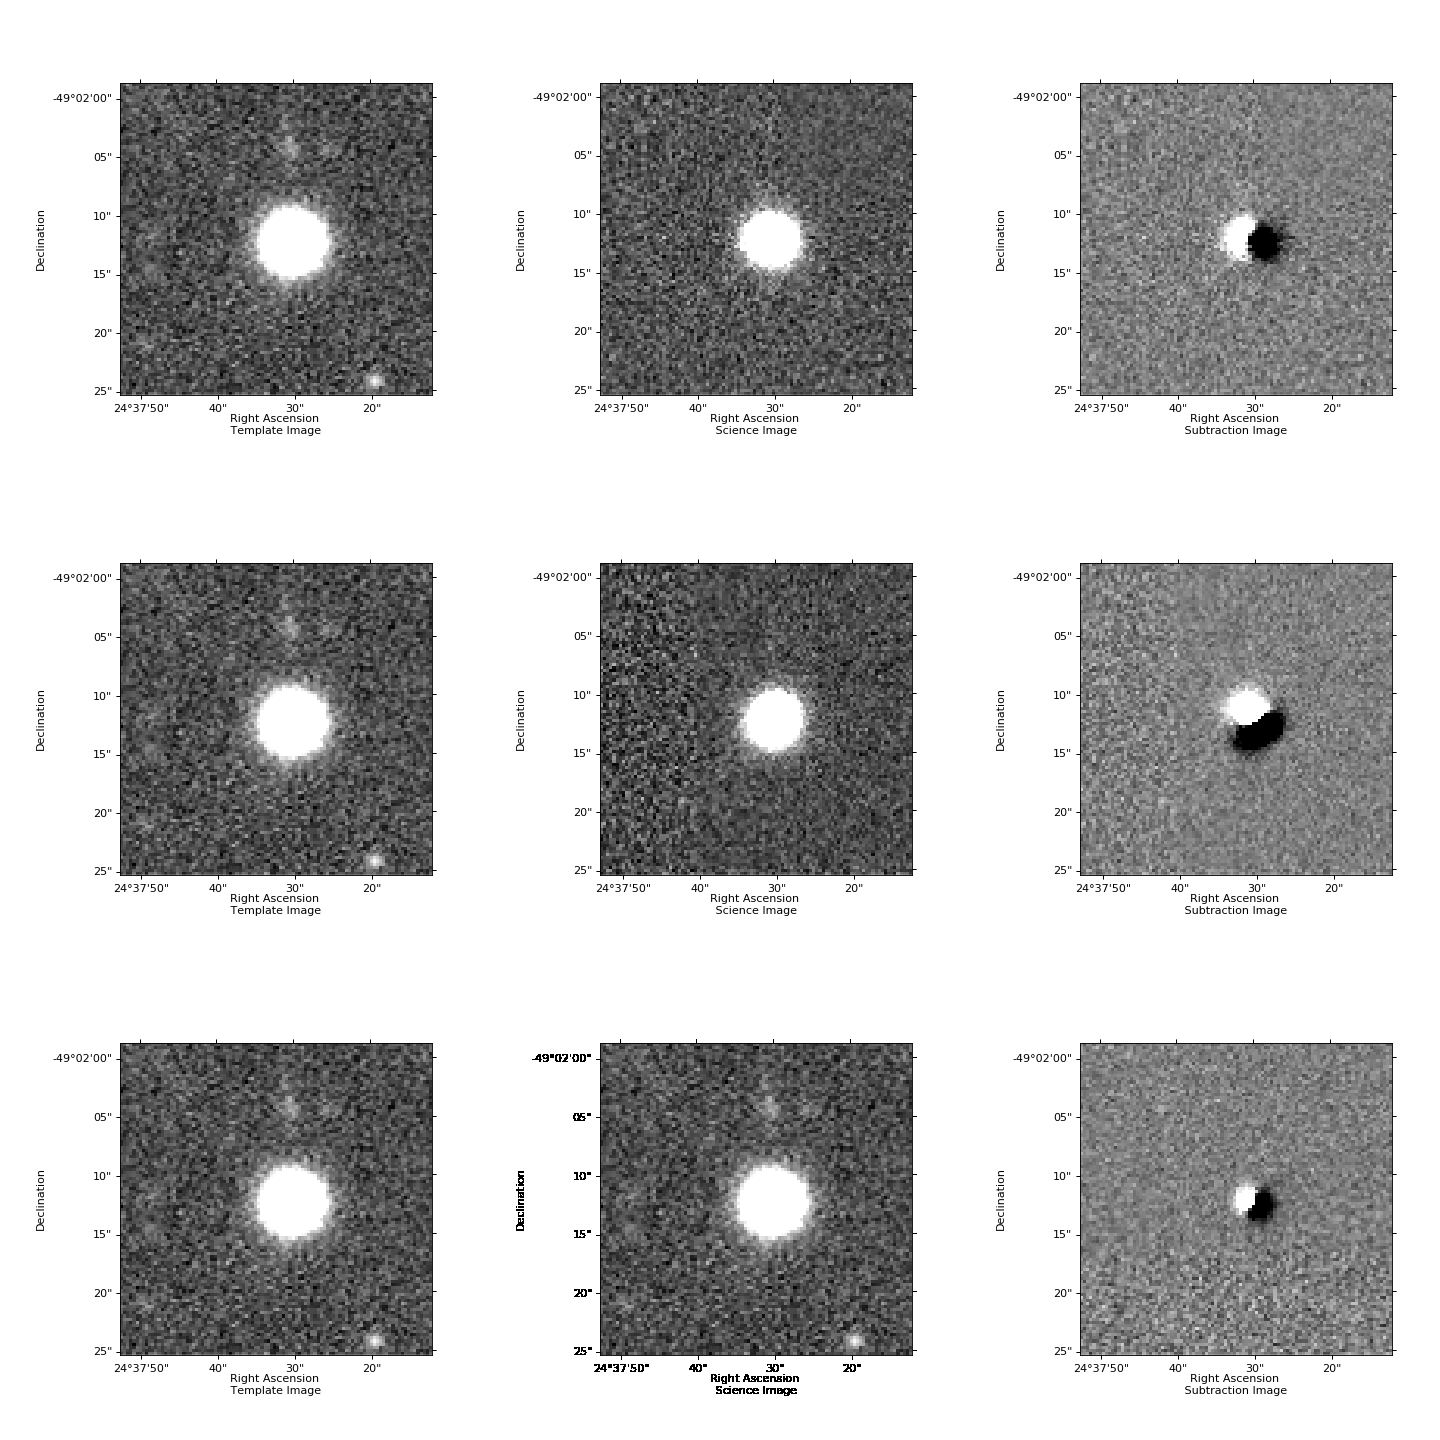

In [11]:
#  Now combine them vertically and save in the final output file
list_im_v1 = [o1, o2,o3]
imgs = [ PIL.Image.open(i) for i in list_im_v1 ]
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)

imgs_comb.save('Final_stamp.png')  

test = Image.open('Final_stamp.png')
test